# Figures associated to immune processing

**You need to tun the notebook 2_ first!!!!**

In [1]:
from cellassign import assign_cats
import gzip
import itertools as itl
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
import triku as tk
import itertools

In [2]:
from functions import adata_plot_KOvsWT, stat_annot_gene
from functions import dict_WT_KO_colors

In [3]:
from datetime import date

today = date.today()
today = today.strftime("%Y_%m_%d")

In [4]:
# Palettes for UMAP gene expression

magma = [plt.get_cmap('magma')(i) for i in np.linspace(0,1, 80)]
magma[0] = (0.88, 0.88, 0.88, 1)
magma = mpl.colors.LinearSegmentedColormap.from_list("", magma[:65])

In [5]:
mpl.rcParams['figure.dpi'] = 200

pd.set_option('display.max_columns', None)

## Functions and variables

In [6]:
%store -r dict_WT_KO_colors
%store -r seed

## Load adata

In [7]:
adata_all_harmony = sc.read_h5ad('adatas/adata_all_harmony.h5')
adata_vasc = adata_all_harmony[adata_all_harmony.obs['cell_type'].isin(['Lymphatic', 'Endothelial', 'Perivascular cell $Il6^+$',
       'Perivascular cell $Inpp4b^+$', 'Schwann cell',])]

In [8]:
sc.pp.filter_genes(adata_vasc, min_counts=1)

Trying to set attribute `.var` of view, copying.


In [9]:
sc.pp.pca(adata_vasc, random_state=seed, n_comps=50)
sce.pp.harmony_integrate(adata_vasc, key='batch', max_iter_harmony=50, plot_convergence=True)
sc.pp.neighbors(adata_vasc, random_state=seed, n_neighbors=int(len(adata_vasc) ** 0.5 * 0.5), metric='cosine', use_rep='X_pca_harmony')
tk.tl.triku(adata_vasc)

sc.pp.pca(adata_vasc, random_state=seed, n_comps=50)
sce.pp.harmony_integrate(adata_vasc, key='batch', max_iter_harmony=50, plot_convergence=True)
sc.pp.neighbors(adata_vasc, random_state=seed, n_neighbors=int(len(adata_vasc) ** 0.5 * 0.5), metric='cosine', use_rep='X_pca_harmony')

2022-08-23 15:58:07,092 - harmonypy - INFO - Iteration 1 of 50
2022-08-23 15:58:07,398 - harmonypy - INFO - Iteration 2 of 50
2022-08-23 15:58:07,731 - harmonypy - INFO - Iteration 3 of 50
2022-08-23 15:58:08,107 - harmonypy - INFO - Iteration 4 of 50
2022-08-23 15:58:08,462 - harmonypy - INFO - Iteration 5 of 50
2022-08-23 15:58:08,942 - harmonypy - INFO - Iteration 6 of 50
2022-08-23 15:58:09,293 - harmonypy - INFO - Iteration 7 of 50
2022-08-23 15:58:09,517 - harmonypy - INFO - Converged after 7 iterations
2022-08-23 15:58:37,923 - harmonypy - INFO - Iteration 1 of 50
2022-08-23 15:58:38,342 - harmonypy - INFO - Iteration 2 of 50
2022-08-23 15:58:38,712 - harmonypy - INFO - Iteration 3 of 50
2022-08-23 15:58:38,993 - harmonypy - INFO - Iteration 4 of 50
2022-08-23 15:58:39,252 - harmonypy - INFO - Iteration 5 of 50
2022-08-23 15:58:39,492 - harmonypy - INFO - Iteration 6 of 50
2022-08-23 15:58:39,723 - harmonypy - INFO - Iteration 7 of 50
2022-08-23 15:58:40,076 - harmonypy - INFO -

### Subpopulation annotation

To do the annotation we used the characterization made by Joost et al. 2020. There are some populations that are not appearing (Krt75+ to Krt18+) and we are not sure about their functional relationship

In [10]:
dict_vasc = {    
                 'Endo 0 (vein)': ['Ackr1', 'Spint2', 'Selp', 'Aqp1', 'Fbln2', 'Ehd4', 'Sele', 'Vwf',  'Pdlim1', 'Tspan7', 'Lepr', 'Chp2', 'Grrp1', 'Fbn1', 'Marveld1', 'Cadm3', 'Nuak1', ],
                 'Endo 1 (capillary)': ['Prag1', 'Cyp1a1', 'Ccl2', 'Rgcc', 'Gdf15', 'Cd36', 'Rgs5', 'Pcdh1', 'Slc30a1', 'Tcf15', 'Pdgfrb', 'Cryab', 'Col6a1', 'Nrarp', 'Col3a1', 'Gclc', ],
    'Endo 2 (capillary)': ['Pald1', 'Nos2', 'Chst1', 'Col4a1', 'Rgcc', 'Adgrl2', 'Hspg2', 'Fscn1', 'Plekha1', 'Fam43a', 'Cxcr4', 'Sipa1', 'Afap1l1', 'Jcad', 'Smagp', 'Adamts7', 'Nrros', ],
    'Endo 3': ['Cp', 'Pf4', 'Fzd6', 'Cxcl2', 'Selp', 'Csf1', 'Mgp', 'Pfkfb3', 'Igfbp5', 'Sdc4', 'Sele', 'F2r', 'Rnd1', 'Wnt5b', ],
    'Endo 4 (artery)': ['Clu', 'Edn1', 'Fbln5', 'Cst3', 'Fbln2', 'Ltbp4', 'Eln', 'Ptprb', 'Fstl1', 'Stmn2', 'Ly6c1', 'Sema3g', 'Podxl', 'Ly6a', 'Htra1', 'S100a4', 'Ace', ],
    'Endo 5': ['Tyrobp', 'Ccl3', 'Fcer1g', 'Srgn', 'Ifitm1', 'Ccl6', 'Alox5ap', 'Lilrb4a', 'Lgals3', 'Cd52', 'Ccl4', 'Rgs1', 'Samsn1', 'Osm', 'Taldo1', 'Lat2', 'Mcpt8', 'Slpi', 'Cd53', ],
    'Peri 0': ['Selenbp1', 'Galk1', 'Tnfrsf9', 'Pkm', 'Pgk1', 'Aldoa', 'Bsg', 'Higd1a', 'Tpi1', 'Ankrd37', 'P4ha2', 'Bnip3l', 'Pfkp', 'Cox7a1', 'Ppp1r3c', 'Kbtbd11', 'Hk1', ],
    'Peri 1': ['Ccl7', 'Ccl11', 'Irak3', 'Procr', 'Bach1', 'Crispld2', 'Cnbp', 'Crem', 'Uap1', 'Eprs', 'Vat1', 'Mpp7', 'Nsd3', 'Dot1l', 'Ccl2', 'Cxcl1', 'Cxcl2', 'Nfkb1', 'Plpp3', 'Il6', 'Steap4', 'Adamts4', 'Tnc', 'Pkdcc', ],
    'Peri 2': ['Vcam1', 'Cgnl1', 'Tgfbi', 'Cd44', 'Snhg1', 'Flnb', 'Hivep2', 'Lhfpl2', 'Arl5b', 'Mcc', 'Cd34', 'Tjp2', 'Gja1', ],
    'Peri 3': ['Nrep', 'Inpp4b', 'Dlk1', 'Sept4', 'Kitl', 'Cyp4b1', 'Abcc9', 'Mgp', 'Col3a1', 'Ano1', 'Marcks', 'Atp1b2', 'Thy1', 'Tppp3', 'Cygb', 'Mrvi1', 'Adap2', ],
    'Peri 4': ['Actg2', 'Nexn', 'Crlf1', 'Tpm2', 'Acta2', 'Myl6', 'Tagln', 'Flna', 'Mustn1', 'Eln', 'Mylk', 'Ndufa4', 'Hcfc1r1', 'Ccdc107', 'Cnn1', 'Dmpk', 'Smtn', ],
    'Lymph 0': ['Fndc1', 'Cavin2', 'Adgrg3', 'Ccl21a', 'Lyve1', 'Gng11', 'Mmrn1', 'Flt4', 'Slc45a3', 'Ramp2', 'Thy1', 'Reln', 'Ptpn18', 'Olfm1', 'Mmrn1', 'Fgl2', 'Prox1', ],
    'Lymph 1': ['Gdf15', 'Pgf', 'Dtx1', 'Nfat5', 'Ugcg', 'Cpne2', 'Cd24a', 'Neo1', 'Nupr1', 'Slc38a4', 'Adarb1', 'Tbc1d4', 'Plaur', 'Ahnak2', 'Retreg2', 'Atp6v1h',  'Olfm1', 'Mmrn1', 'Fgl2', 'Prox1', ],
    'Schwann cell': ['Mpz', 'Cryab', 'Mbp', 'Plp1', 'Sema3b', 'Egfl8', 'Mal', 'Limch1', 'Gatm', 'Dbi', 'Kcna1', 'Cnp', 'Prx', 'Ncmap', 'Cadm4', 'Plekha4', 'Cldn19', ]
                  }

In [11]:
dict_vasc_colors = {'Endo 0 (vein)': "#8E0C6F",
                    'Endo 1 (capillary)': "#AE54B8",
                    'Endo 2 (capillary)': "#4D0765",
                    'Endo 3': "#20668D",
                    'Endo 4 (artery)': "#229EB2",
                    'Endo 5': "#77ECF1",
                    'Lymph 0': "#FF5599",
                    'Lymph 1': "#D40055",
                    'Peri 0': "#D3BC5F",
                    'Peri 1': "#A5901A",
                    'Peri 2': "#A05A2C",
                    'Peri 3': "#702A17",
                    'Peri 4': "#4E1302",
                    'Schwann cell': "#FF9955"}

In [12]:
sc.tl.leiden(adata_vasc, resolution=4)
assign_cats(adata_vasc, dict_cats=dict_vasc, min_score=0.4, quantile_gene_sel=0.65, key_added='subtype')

adata_vasc.uns['subtype_colors'] = list(dict_vasc_colors.values())

... storing 'subtype' as categorical


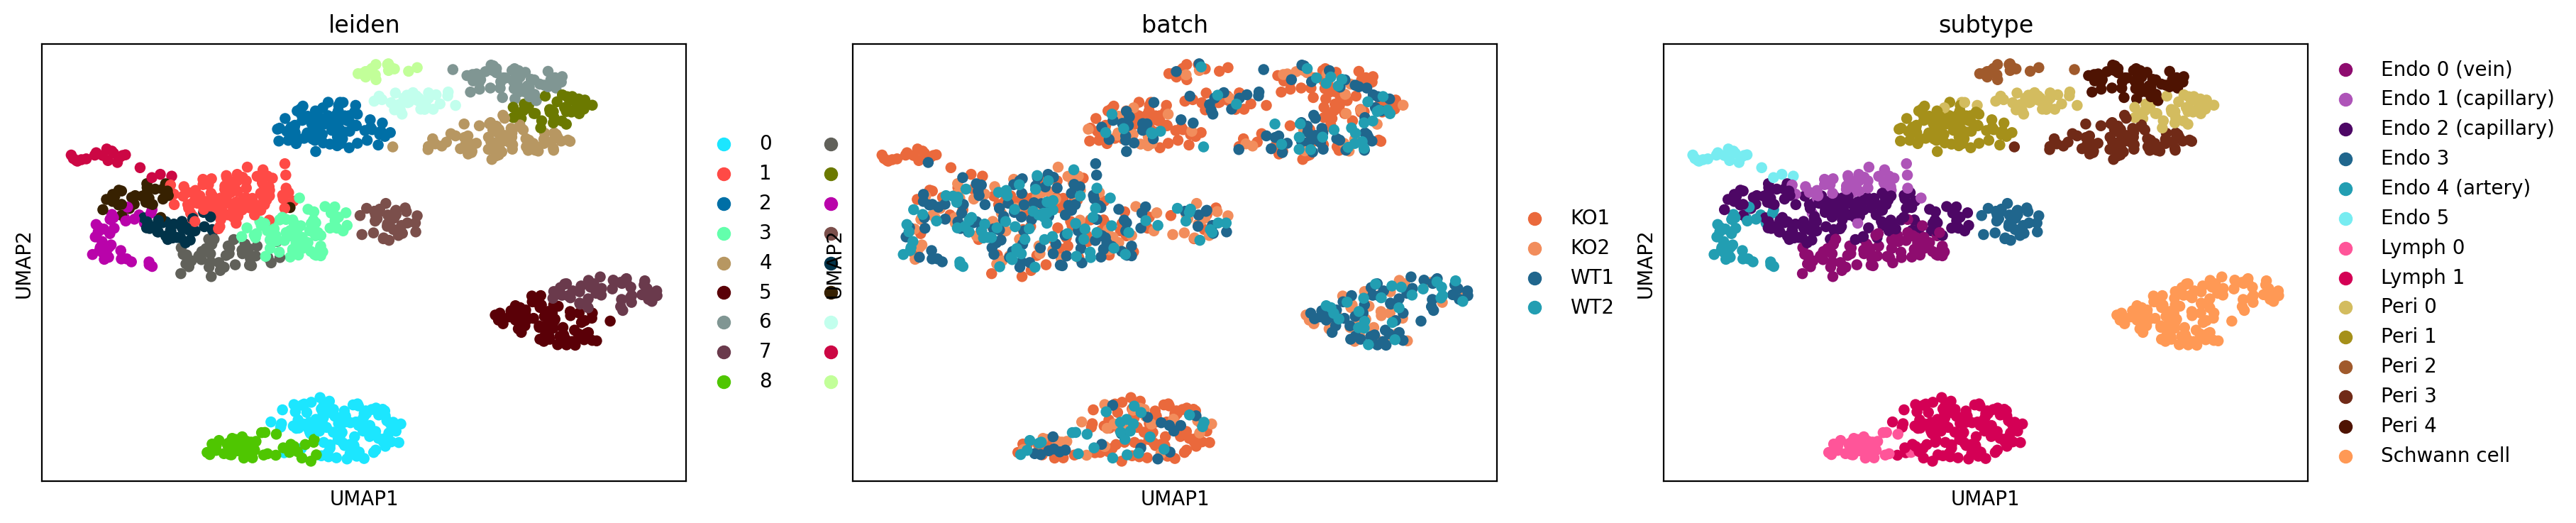

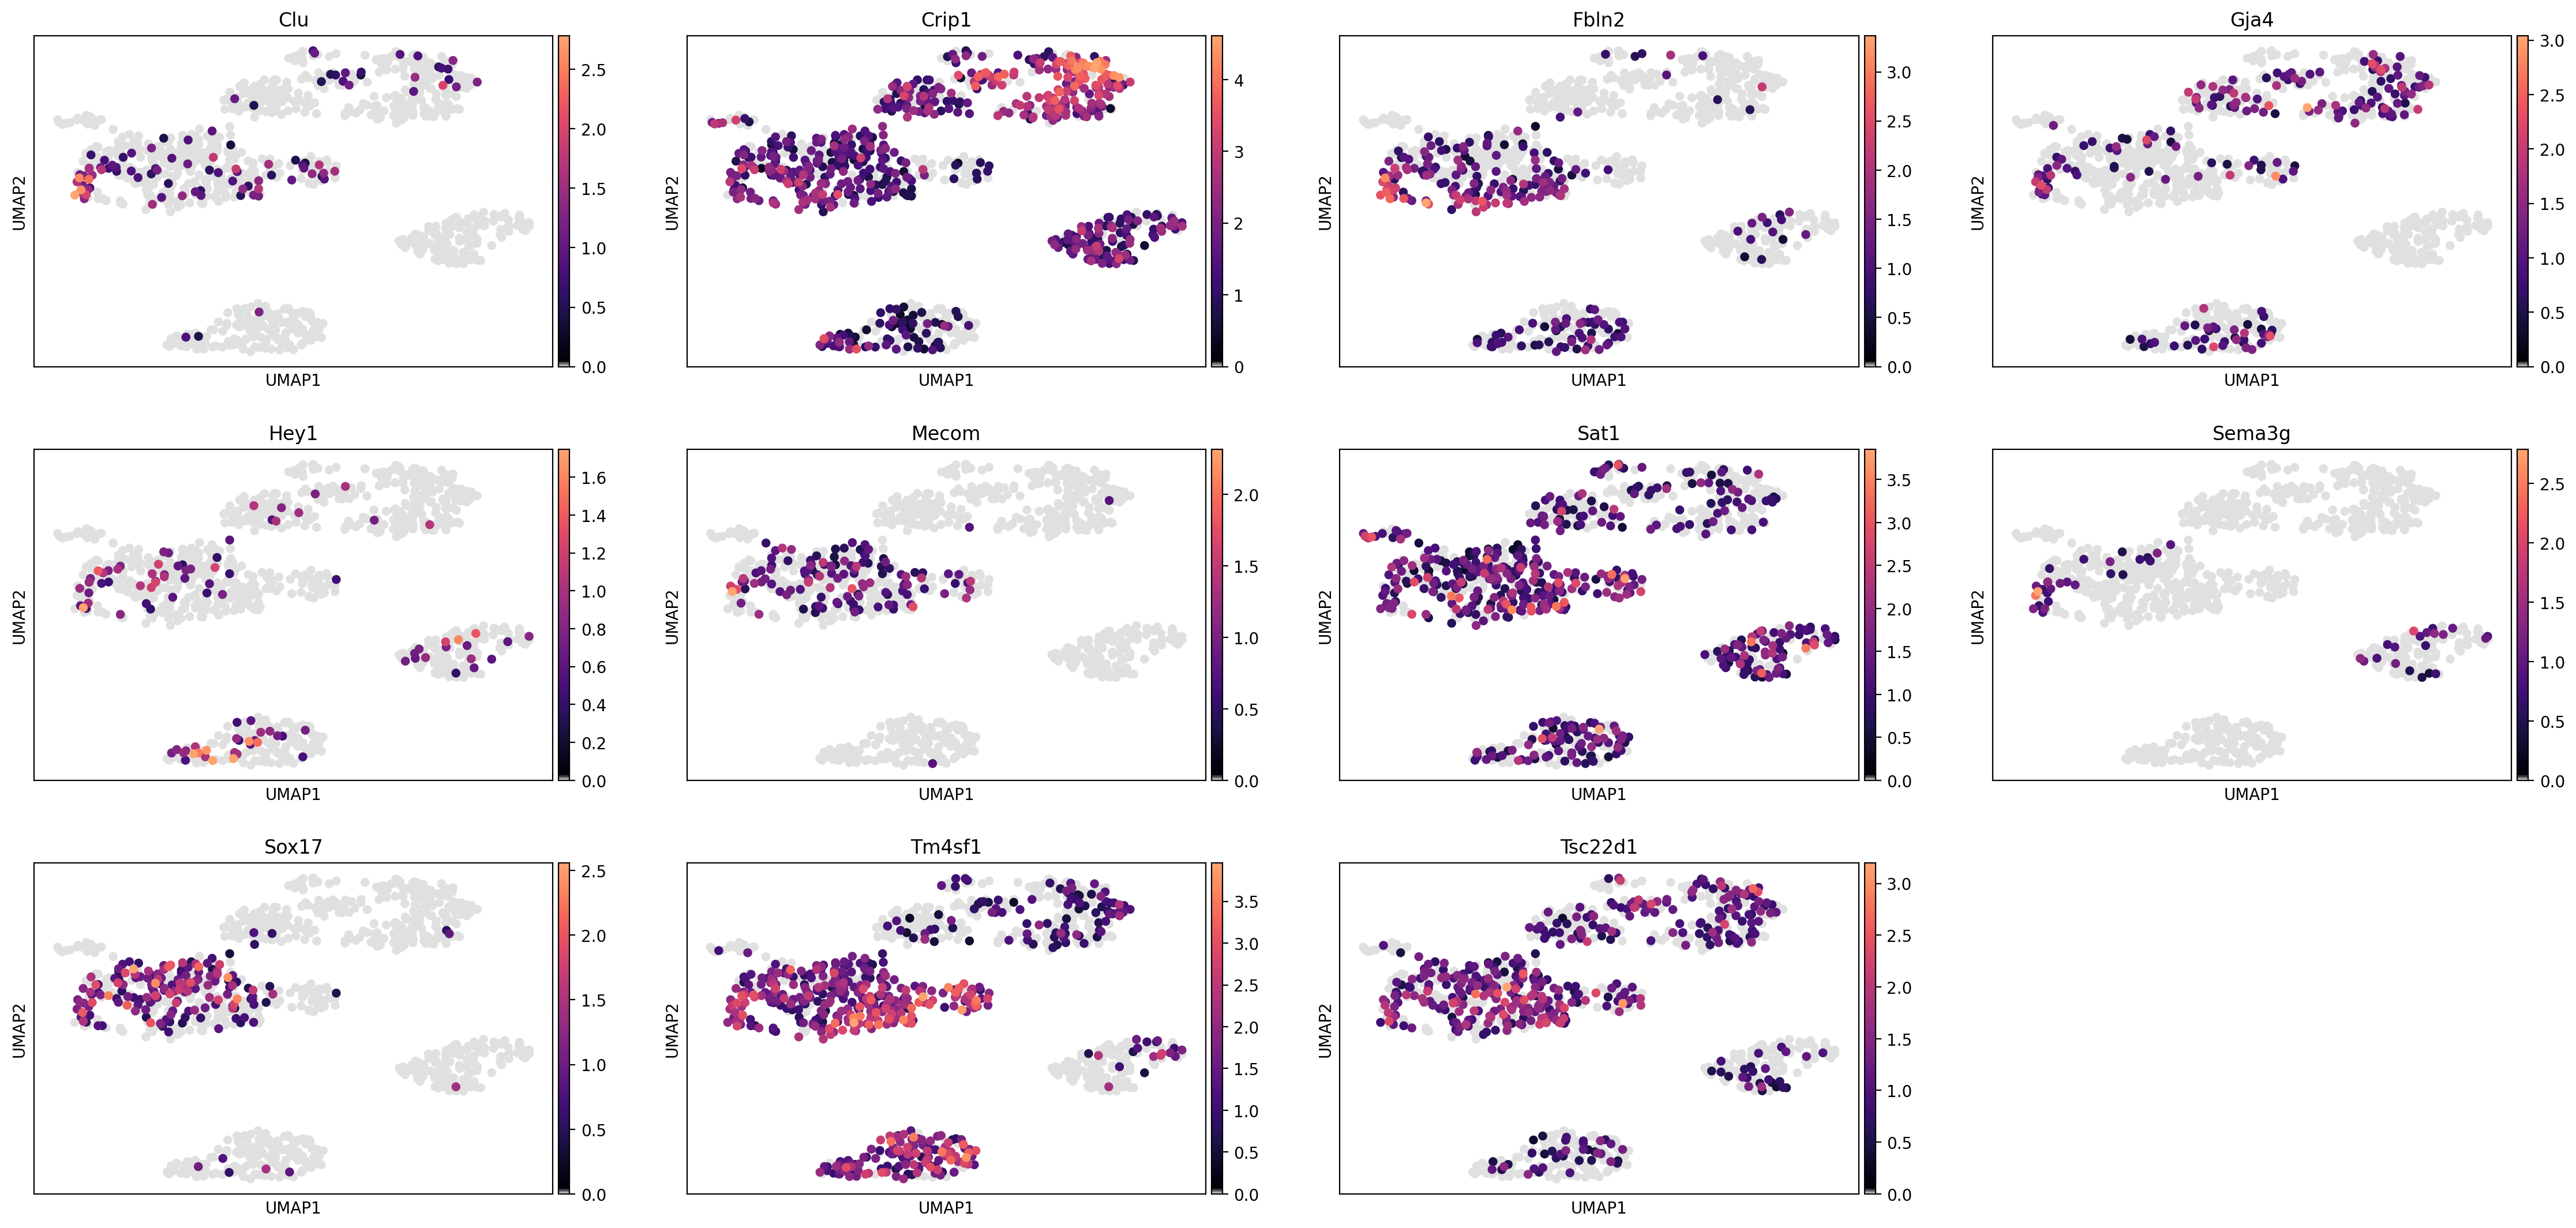

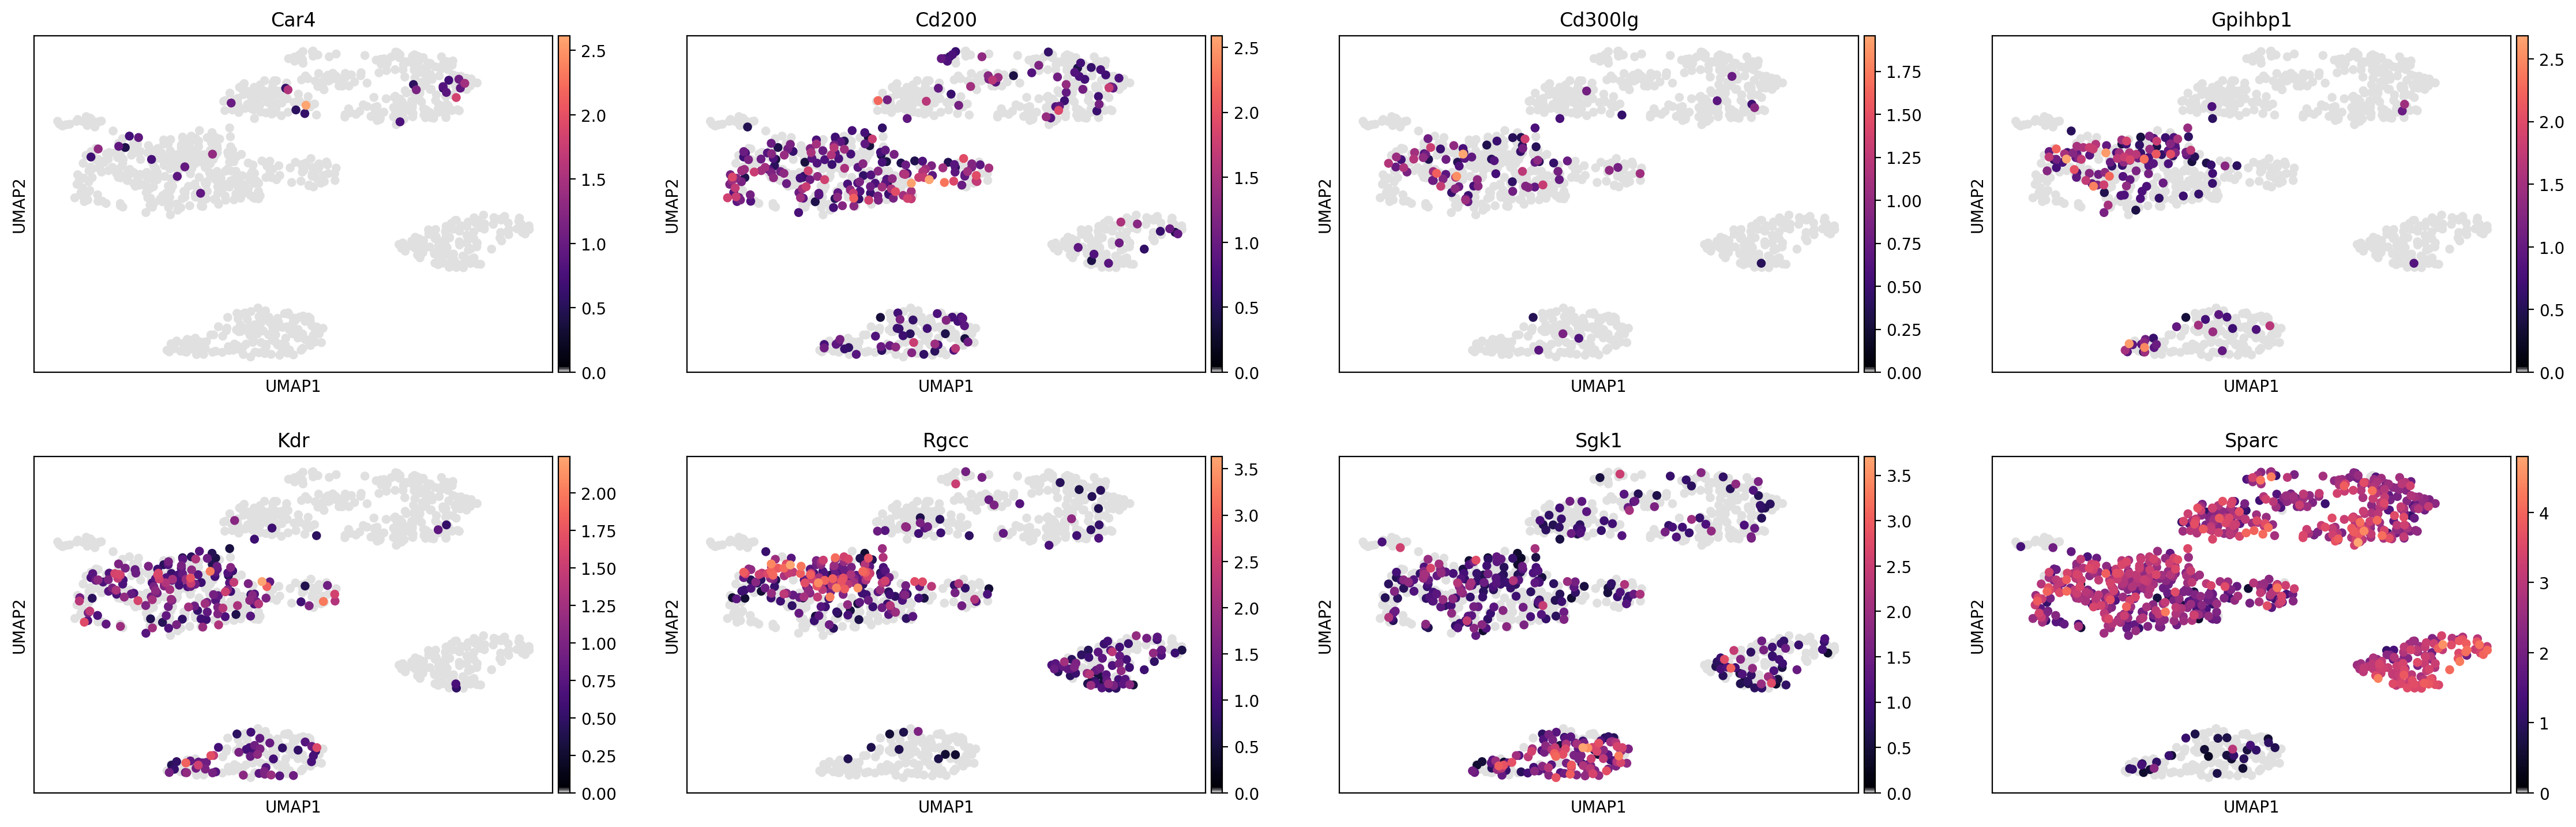

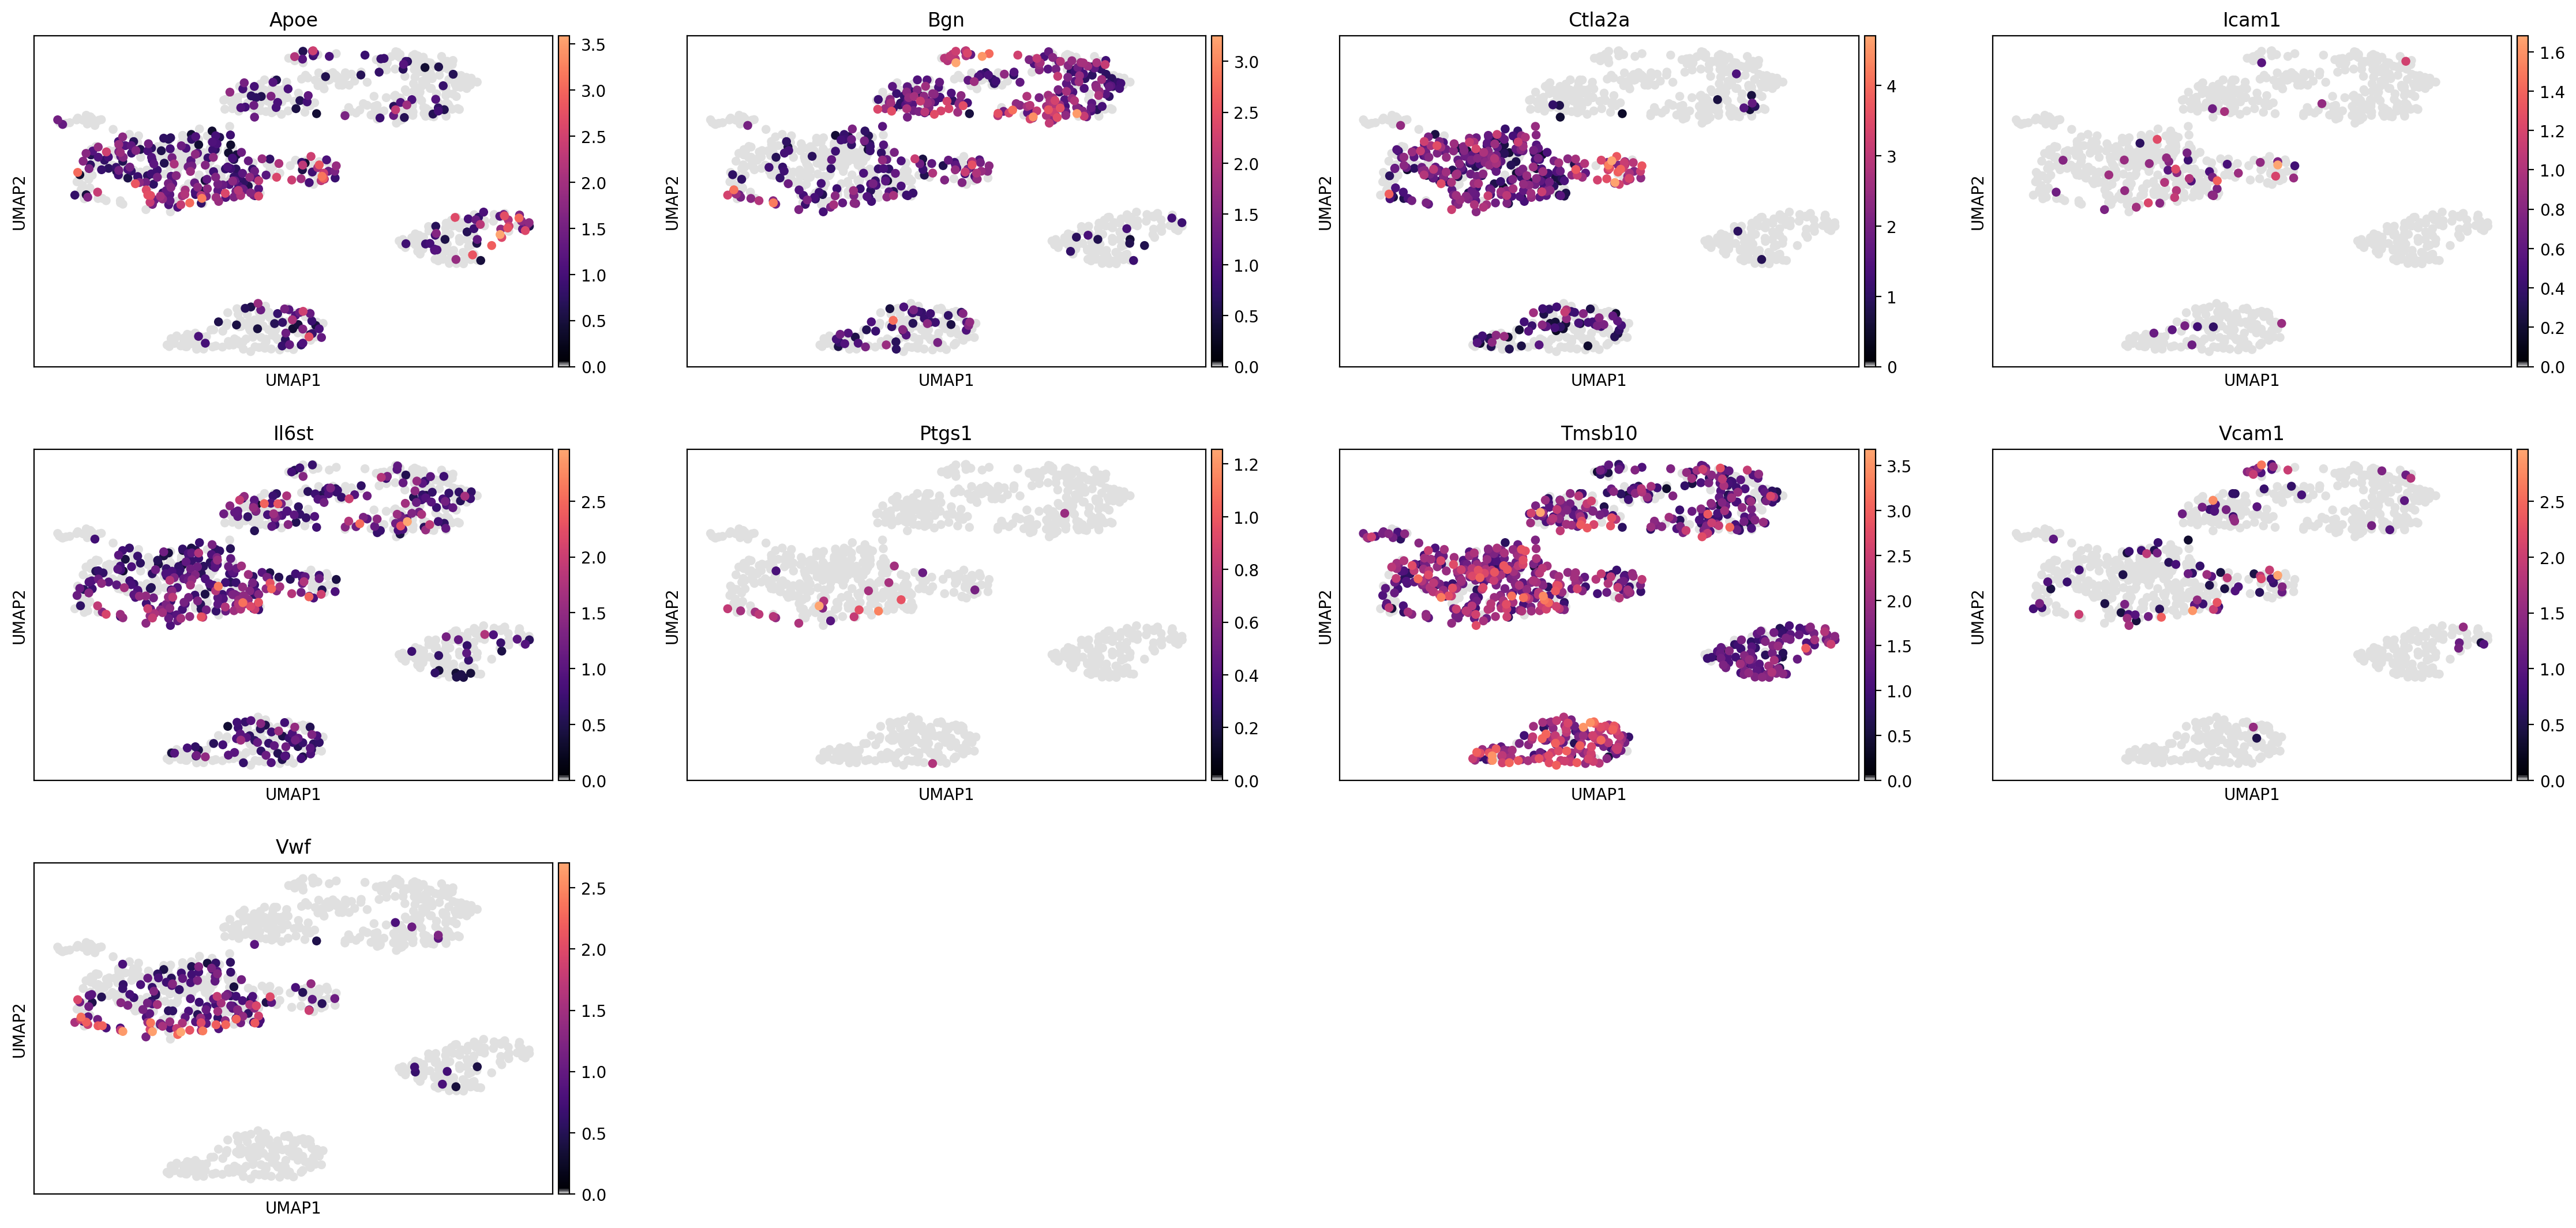

In [13]:
sc.tl.umap(adata_vasc, min_dist=0.85)
sc.tl.leiden(adata_vasc, resolution=2)


# Markers extracte from Kalucka et al. 2020 (mmc5)

sc.pl.umap(adata_vasc, color=['leiden', 'batch', 'subtype'])
sc.pl.umap(adata_vasc, color=['Clu', 'Crip1', 'Fbln2', 'Gja4', 'Hey1', 'Mecom', 'Sat1', 'Sema3g', 'Sox17', 'Tm4sf1', 'Tsc22d1',], cmap=magma, legend_loc='on data') # Artery
sc.pl.umap(adata_vasc, color=['Car4', 'Cd200', 'Cd300lg', 'Gpihbp1', 'Kdr', 'Rgcc', 'Sgk1', 'Sparc',], cmap=magma, legend_loc='on data') # Capillary
sc.pl.umap(adata_vasc, color=['Apoe', 'Bgn', 'Ctla2a', 'Icam1', 'Il6st', 'Ptgs1', 'Tmsb10', 'Vcam1', 'Vwf', ], cmap=magma, legend_loc='on data') # Vein

## UMAP of fibroblast subpopulations and batch

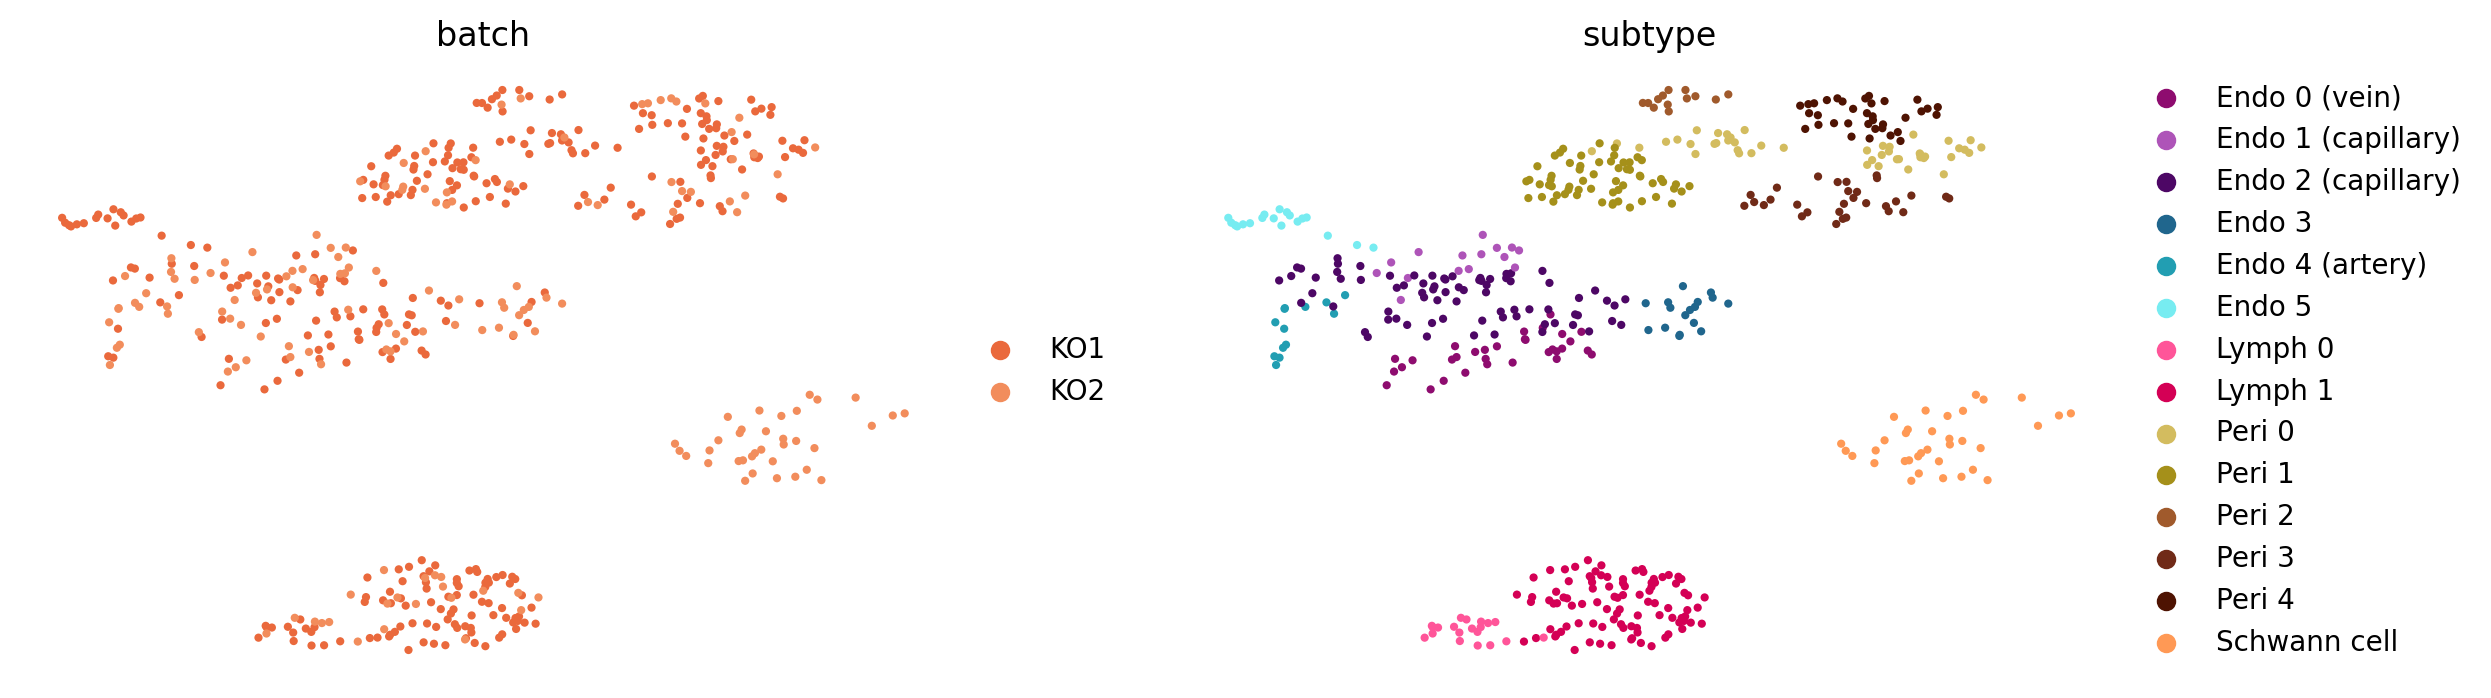

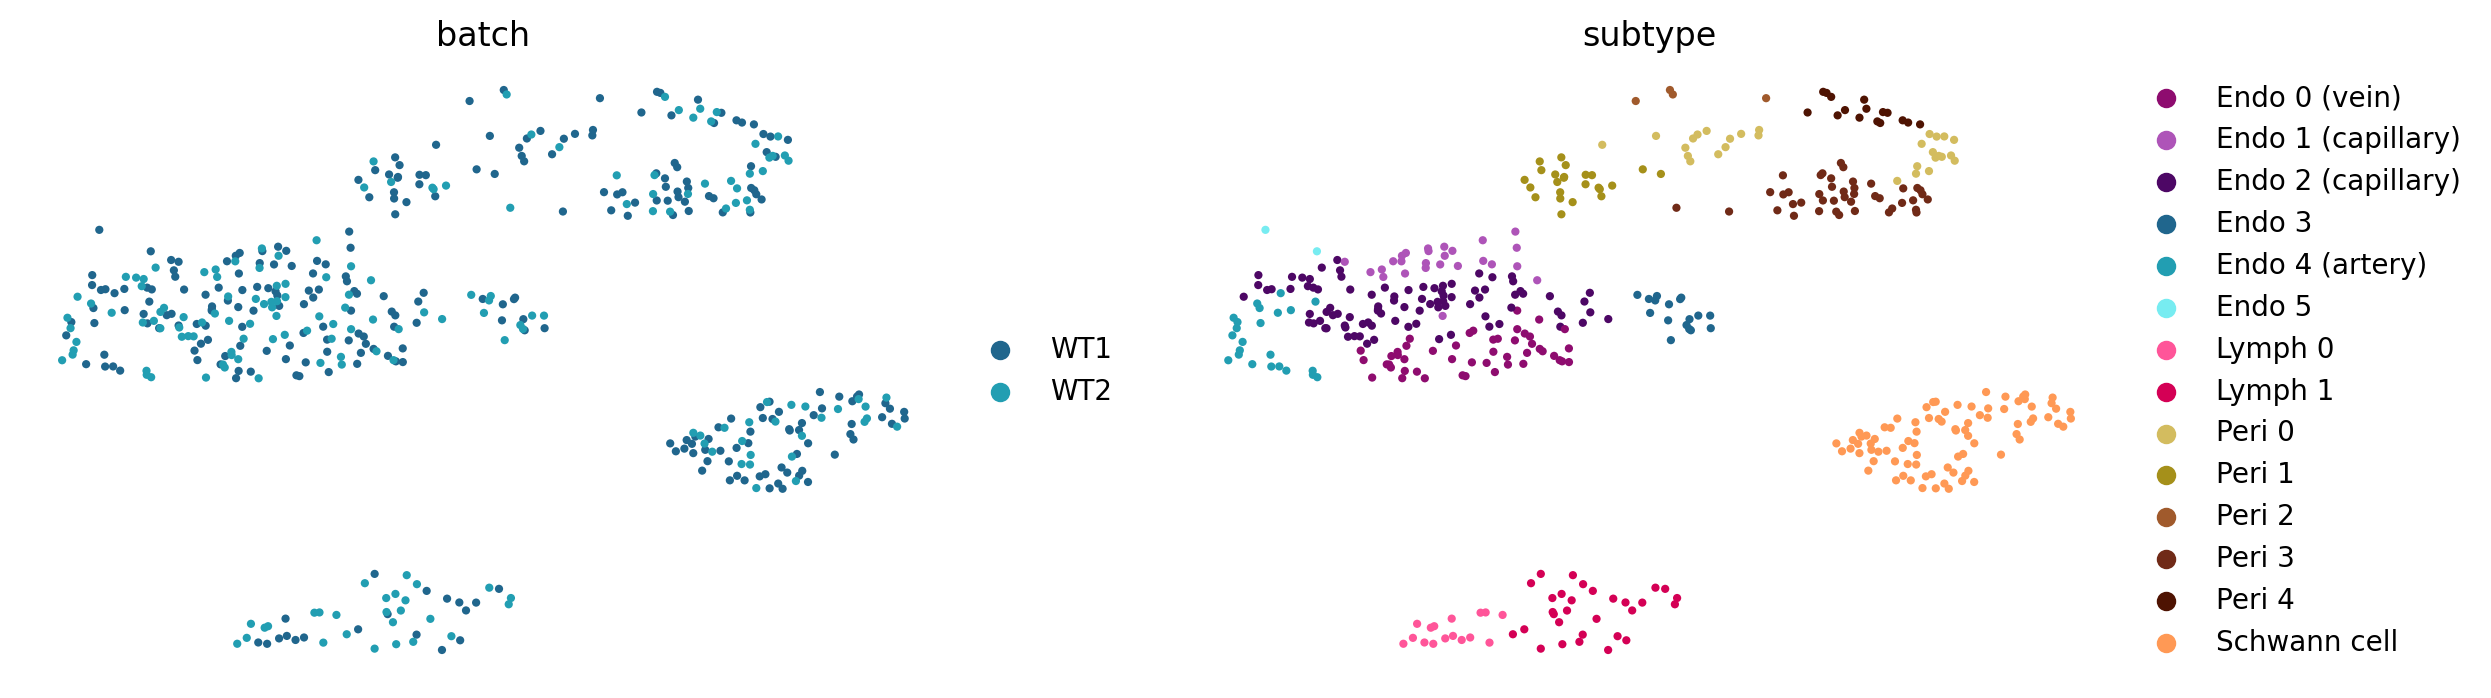

In [14]:
sc.pl.umap(adata_vasc[adata_vasc.obs['batch'].isin(['KO1', 'KO2'])] , color=['batch', 'subtype'], ncols=2, frameon=False, cmap=magma, size=35)
sc.pl.umap(adata_vasc[adata_vasc.obs['batch'].isin(['WT1', 'WT2'])] , color=['batch', 'subtype'], ncols=2, frameon=False, cmap=magma, size=35)

## Proportion of cell types within WT and KO

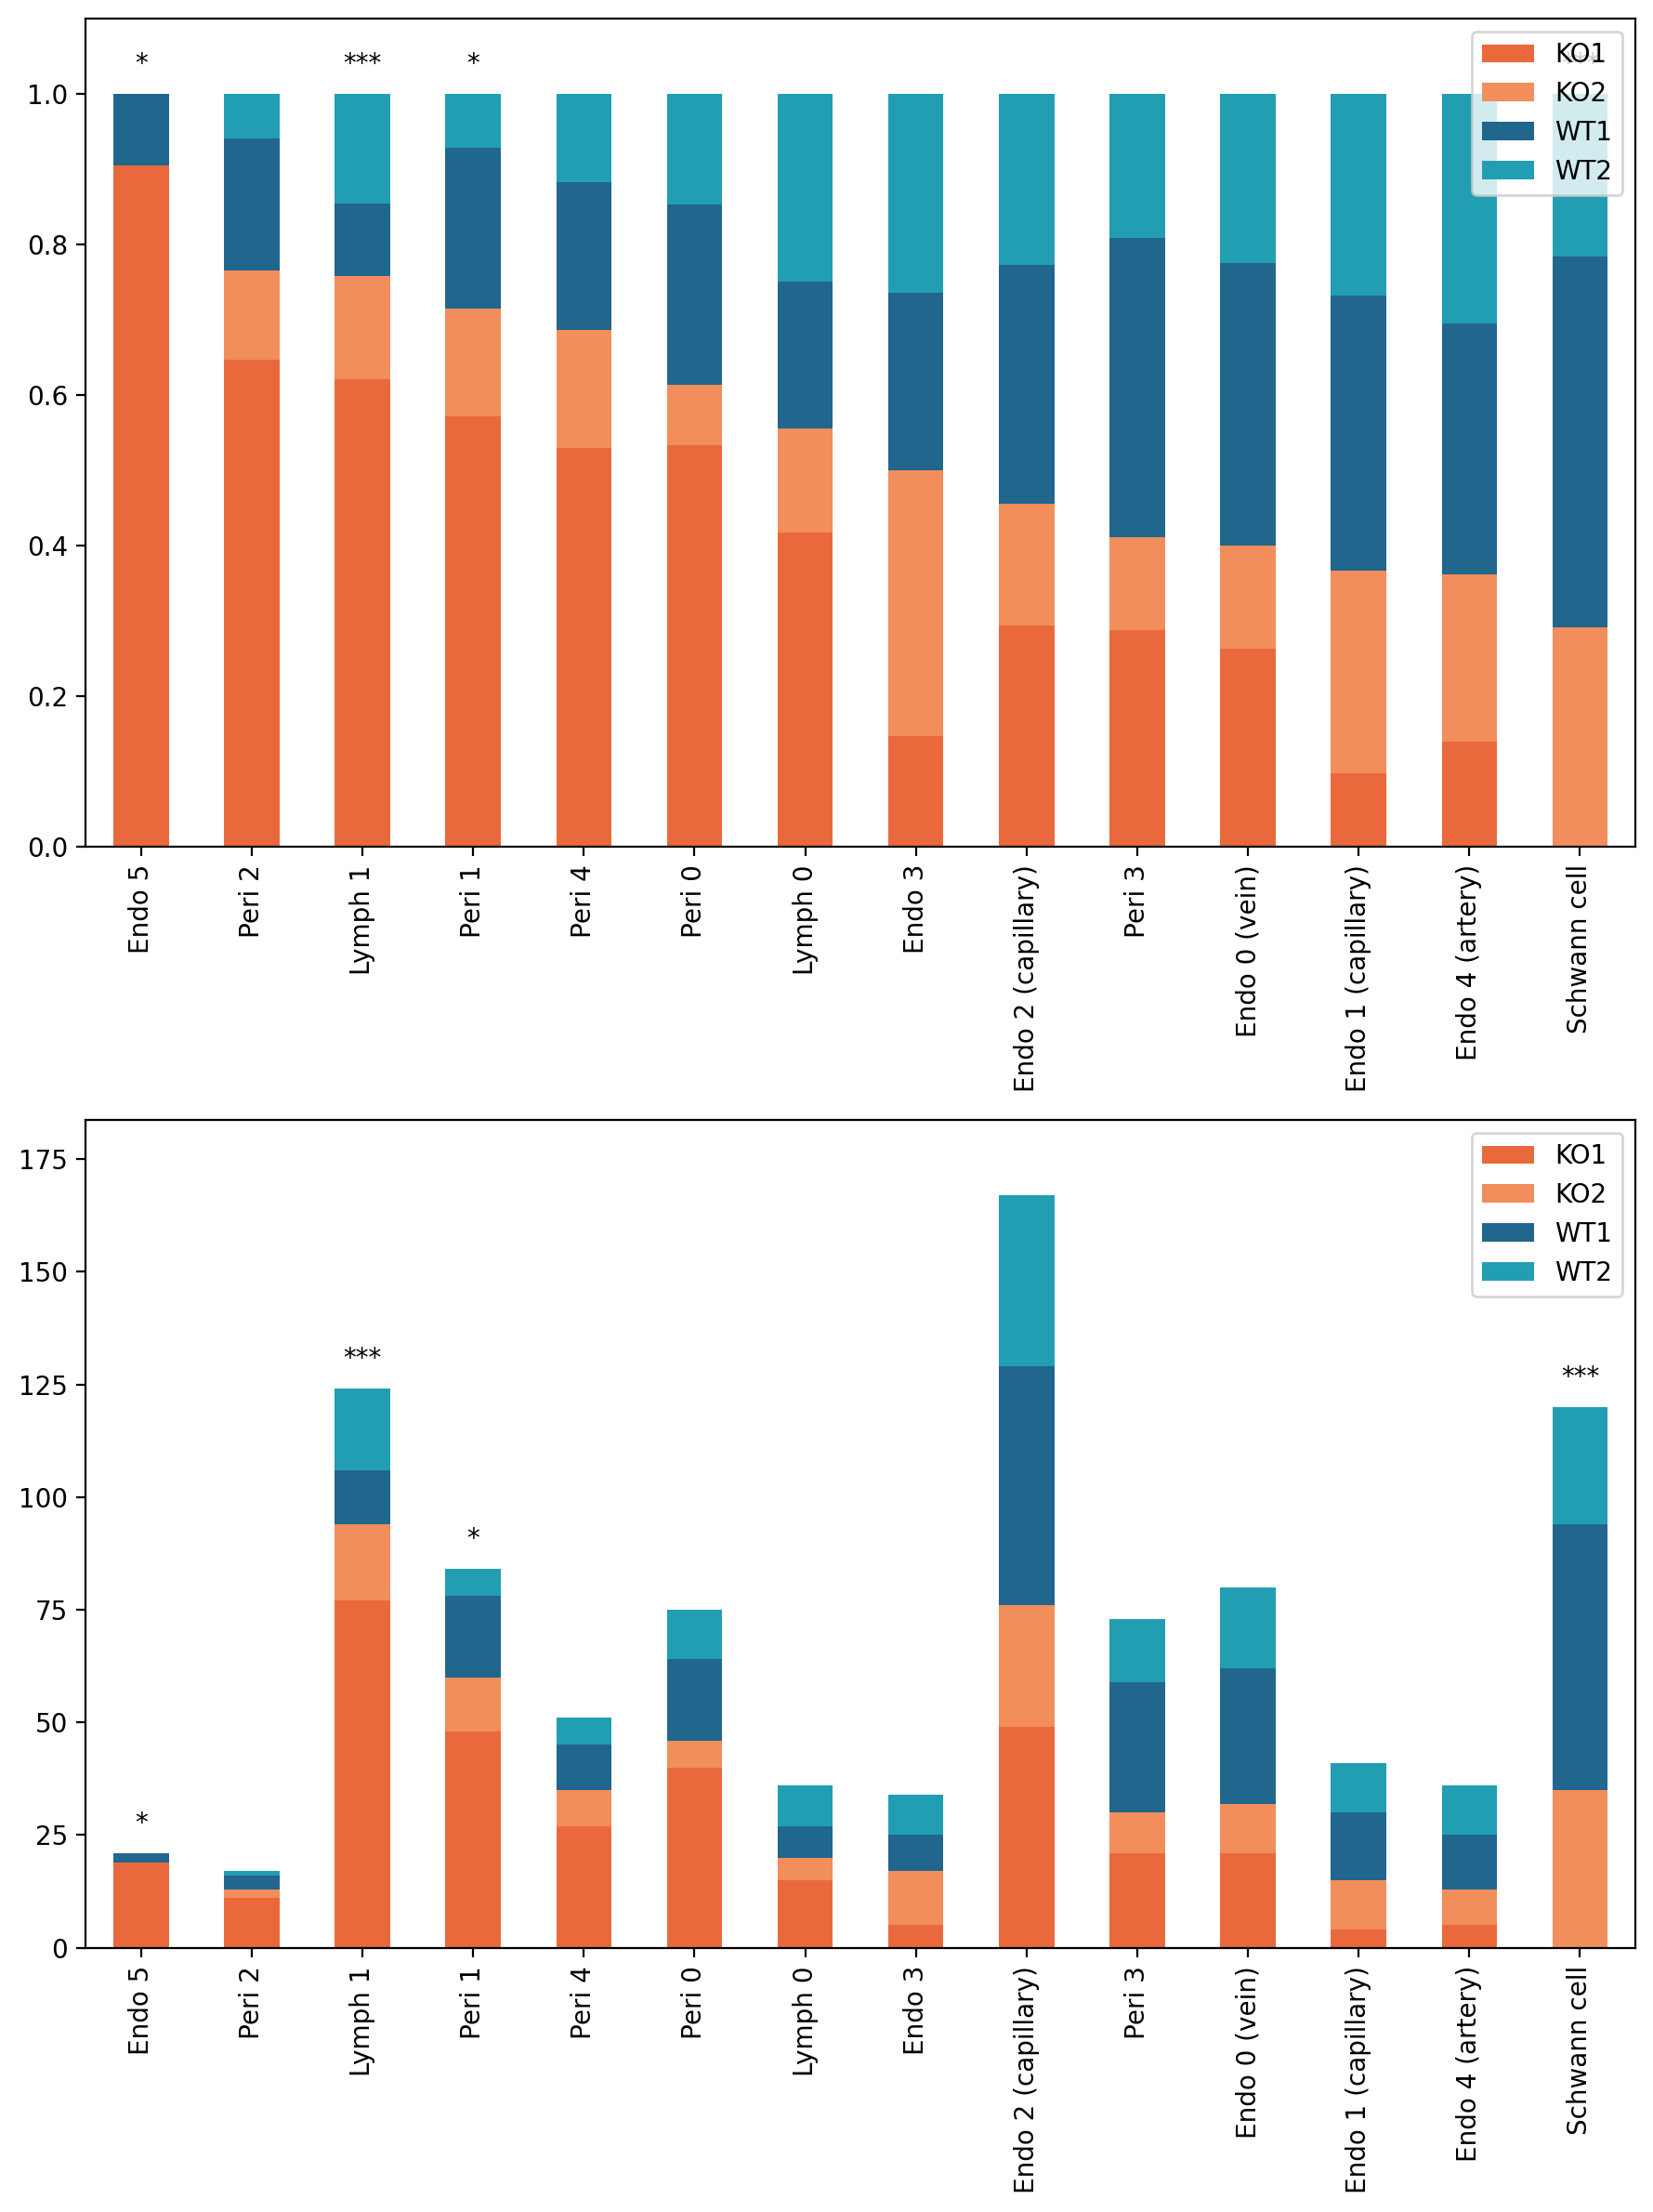

In [15]:
adata_plot_KOvsWT(adata_vasc, list(dict_vasc.keys()), col_cell_type='subtype')

## Table with markers and p-values

In [16]:
sc.tl.rank_genes_groups(adata_vasc, groupby='subtype')
names = pd.DataFrame(adata_vasc.uns['rank_genes_groups']['names'])
pvals = pd.DataFrame(adata_vasc.uns['rank_genes_groups']['pvals_adj'])

In [17]:
# Create a DataFrame with 30 most important genes
list_dfs = []
for subtype, genes in dict_vasc.items():
    df = pd.DataFrame({f'{subtype} genes': names[subtype], f'p-value {subtype}': pvals[subtype]}, dtype=object)
    df_short = df[df[f'{subtype} genes'].isin(genes)].sort_values(by=f'p-value {subtype}', ascending=True).iloc[:30].reset_index(drop=True)
    df[f'p-value {subtype}'] = df[f'p-value {subtype}'].apply(lambda x: '%.3E' % x).values.tolist()
    list_dfs.append(df_short)

In [18]:
df_all_celltypes = pd.concat(list_dfs, axis=1)
df_all_celltypes.to_csv(f'results/{today}-markers_4_pops.csv', index=False)
df_all_celltypes

Endo 0 (vein) genes p-value Endo 0 (vein) Endo 1 (capillary) genes  \
0                 Aqp1            9.0324e-34                     Rgcc   
1                 Selp           2.20146e-16                    Pcdh1   
2               Pdlim1           1.02739e-14                    Gdf15   
3                Fbln2           4.03776e-14                  Slc30a1   
4                 Ehd4           8.75305e-12                    Prag1   
5                 Sele           2.47578e-11                     Cd36   
6                  Vwf           6.42098e-11                     Ccl2   
7               Tspan7           3.47225e-10                   Cyp1a1   
8                Ackr1            6.3784e-08                     Gclc   
9                 Lepr           7.15175e-07                    Tcf15   
10              Spint2           8.81906e-07                     Rgs5   
11               Grrp1           3.90774e-06                    Nrarp   
12                Chp2           5.37249e-05                    Cryab   
13            Marveld1           0.000289559                   Pdgfrb   
14                Fbn1            0.00361474                   Col6a1   
15               Nuak1            0.00674436                   Col3a1   
16               Cadm3             0.0587493                      NaN   
17                 NaN                   NaN                      NaN   
18                 NaN                   NaN                      NaN   
19                 NaN                   NaN                      NaN   
20                 NaN                   NaN                      NaN   
21                 NaN                   NaN                      NaN   
22                 NaN                   NaN                      NaN   
23                 NaN                   NaN                      NaN   

   p-value Endo 1 (capillary) Endo 2 (capillary) genes  \
0                 3.11761e-07                     Rgcc   
1                  5.1697e-07                   Adgrl2   
2                 1.58217e-06                    Fscn1   
3                 5.02559e-06                   Col4a1   
4                 1.25958e-05                   Fam43a   
5                 4.99544e-05                    Hspg2   
6                 0.000364408                    Cxcr4   
7                   0.0011806                    Nrros   
8                  0.00986305                    Smagp   
9                   0.0349585                     Jcad   
10                   0.096346                     Nos2   
11                   0.180374                    Pald1   
12                   0.335112                  Afap1l1   
13                   0.773088                  Plekha1   
14                   0.811999                    Sipa1   
15                    0.85858                    Chst1   
16                        NaN                  Adamts7   
17                        NaN                      NaN   
18                        NaN                      NaN   
19                        NaN                      NaN   
20                        NaN                      NaN   
21                        NaN                      NaN   
22                        NaN                      NaN   
23                        NaN                      NaN   

   p-value Endo 2 (capillary) Endo 3 genes p-value Endo 3  \
0                 8.00374e-22          Mgp    1.00101e-05   
1                 7.66286e-19         Csf1    3.23904e-05   
2                 5.22174e-16           Cp    0.000120483   
3                 3.03896e-15         Fzd6    0.000247763   
4                 3.93923e-12         Sele    0.000262713   
5                 4.28304e-12       Igfbp5    0.000374266   
6                 1.68483e-10         Selp    0.000559009   
7                 3.68248e-07          Pf4     0.00183625   
8                 1.13432e-06        Cxcl2     0.00279282   
9                 6.69465e-06          F2r     0.00298397   
10                8.46168e-06        Wnt5b      0.01881

## Dotplot with markers of fibroblast subtypes

{'mainplot_ax': <AxesSubplot:>,
 'size_legend_ax': <AxesSubplot:title={'center':'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <AxesSubplot:title={'center':'Mean expression\nin group'}>}

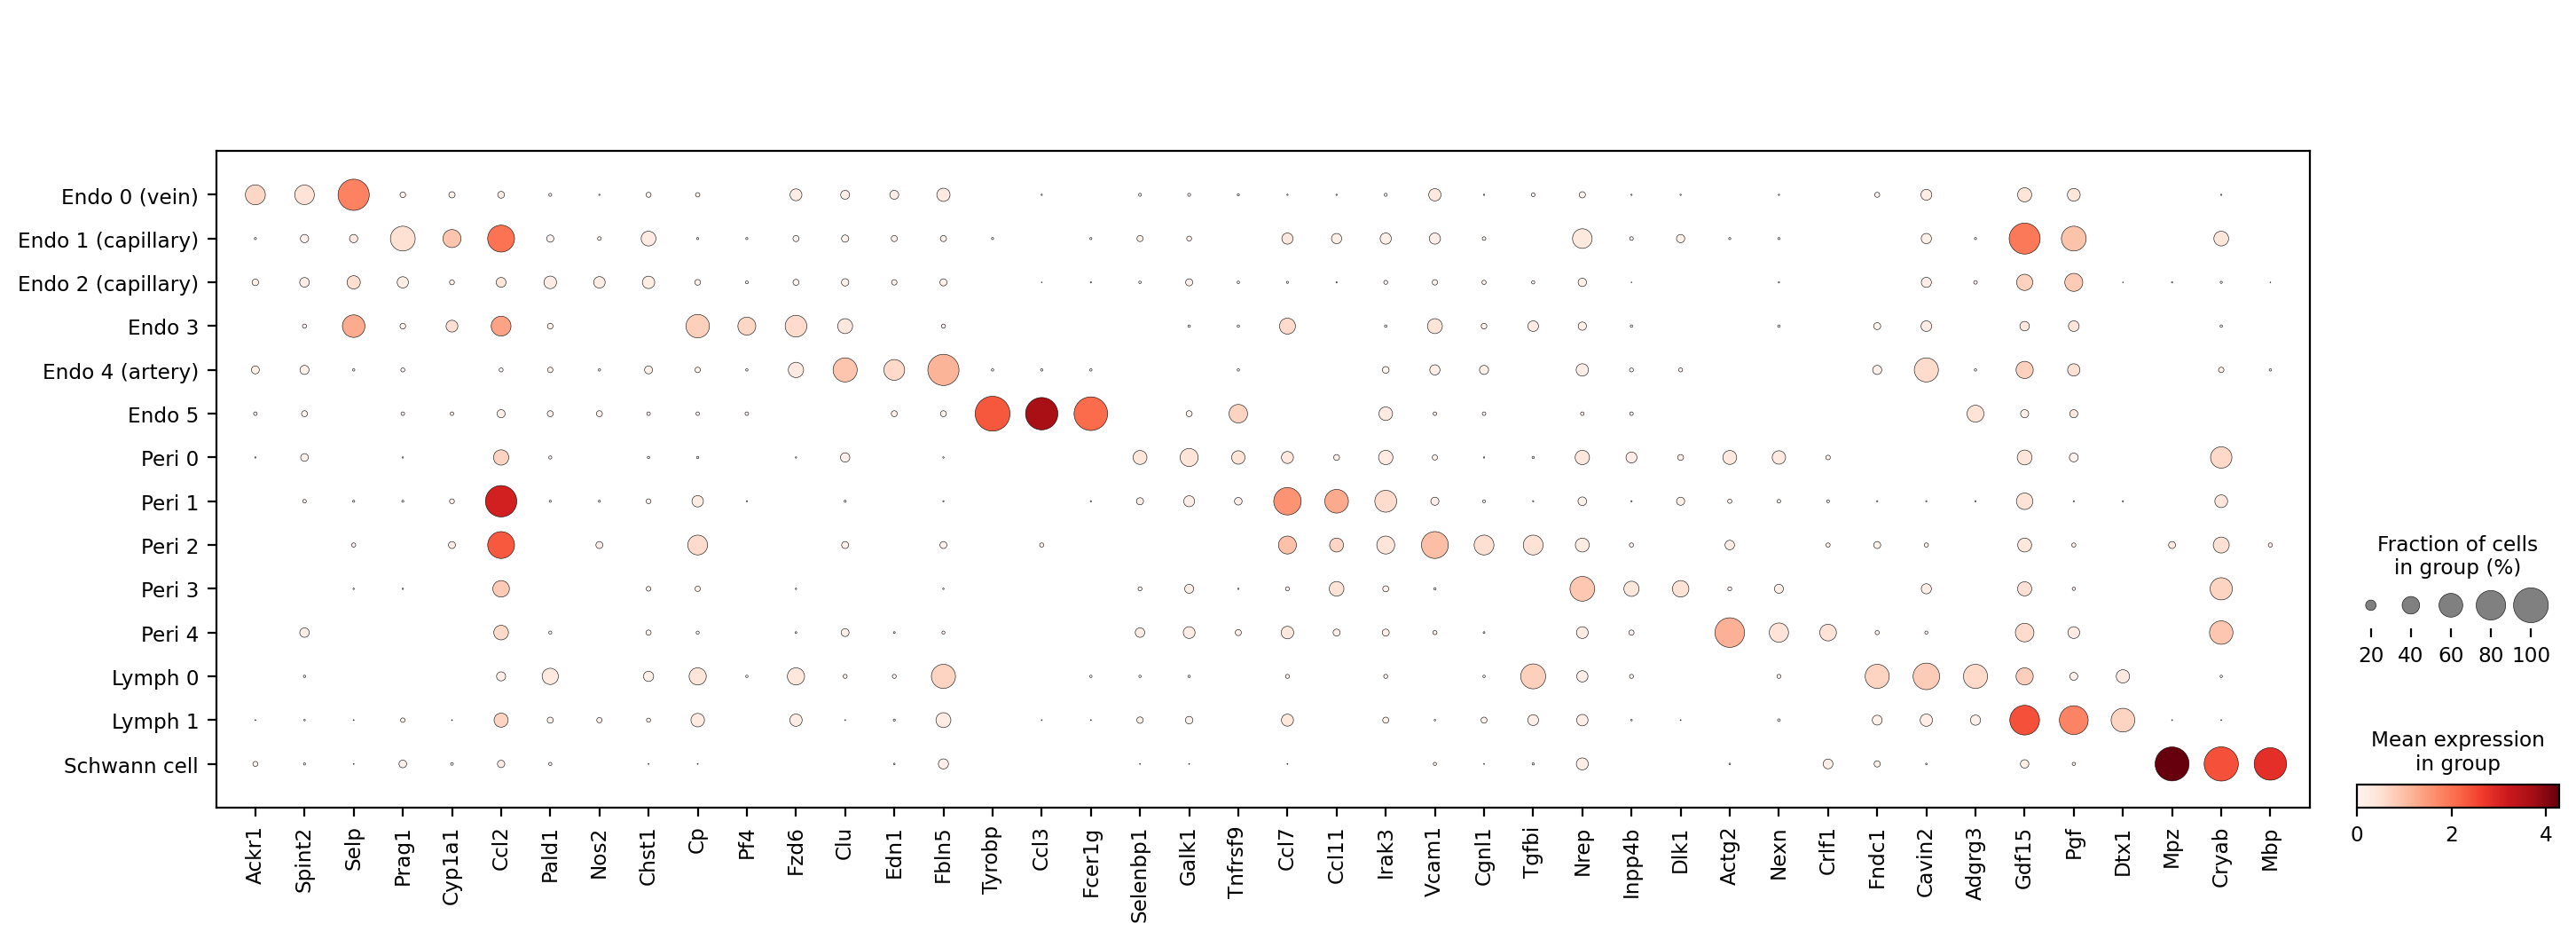

In [19]:
sc.pl.dotplot(adata_vasc, groupby='subtype', var_names=np.array([i[:3] for i in dict_vasc.values()]).ravel(), dendrogram=False, show=False, 
             categories_order=list(dict_vasc.keys()))

## UMAP highlighting the expression of specific markers

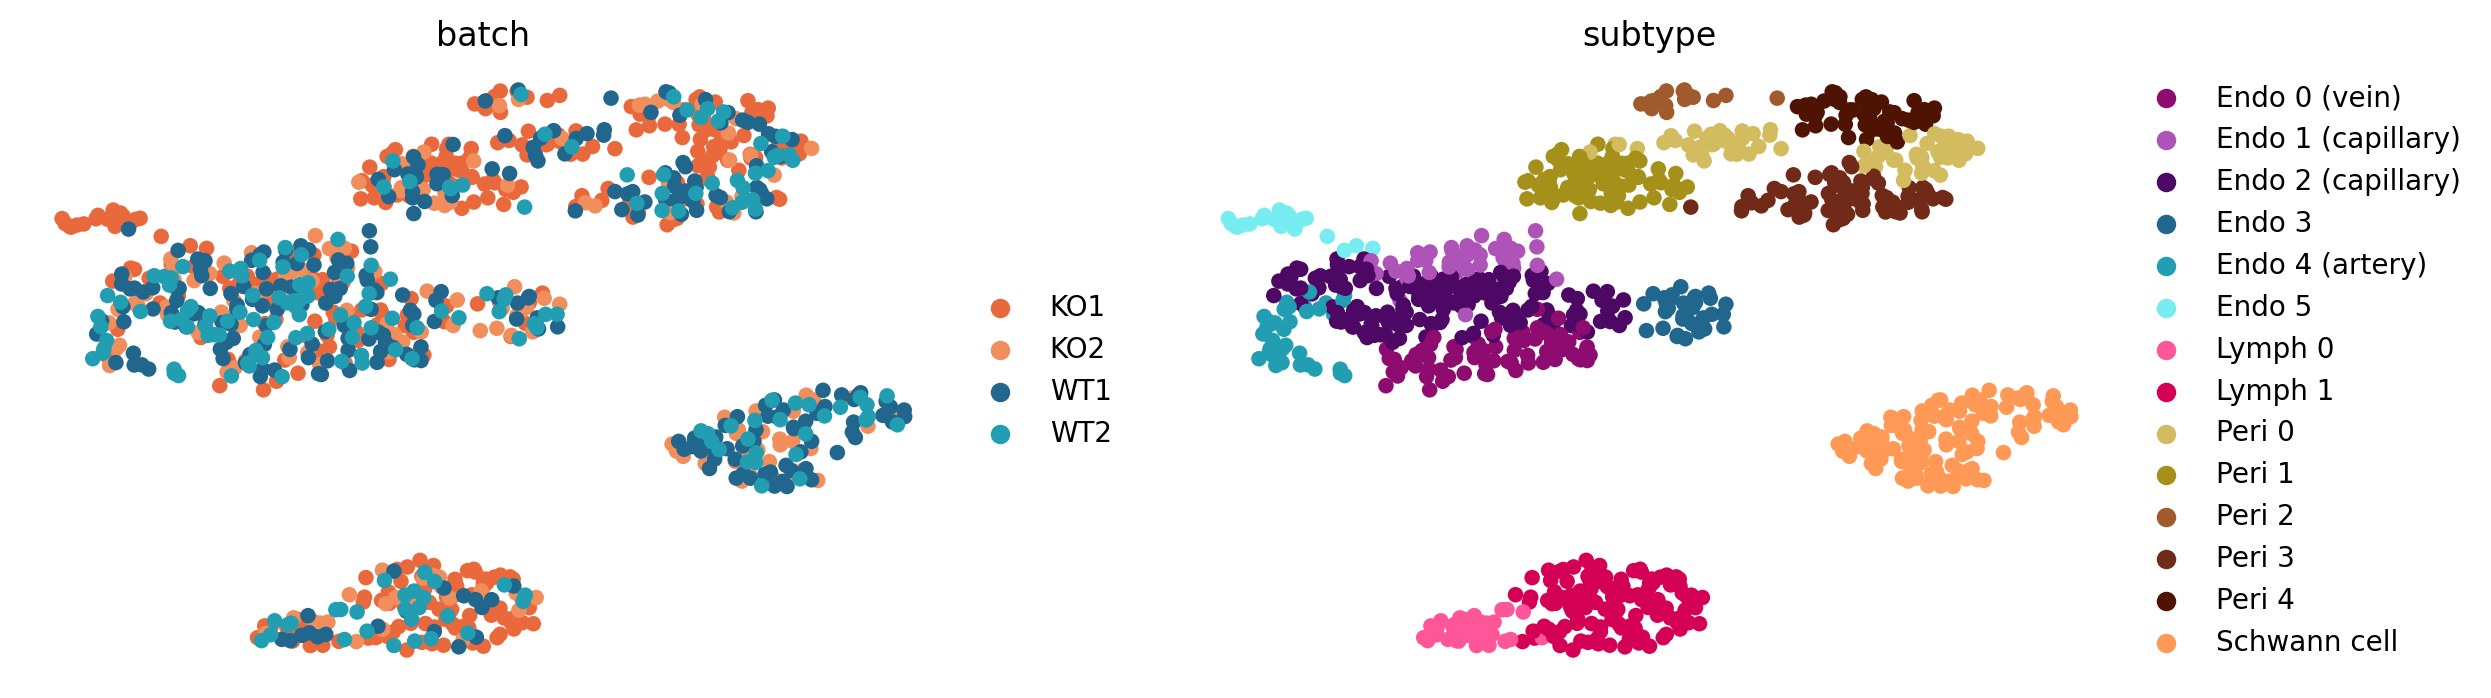

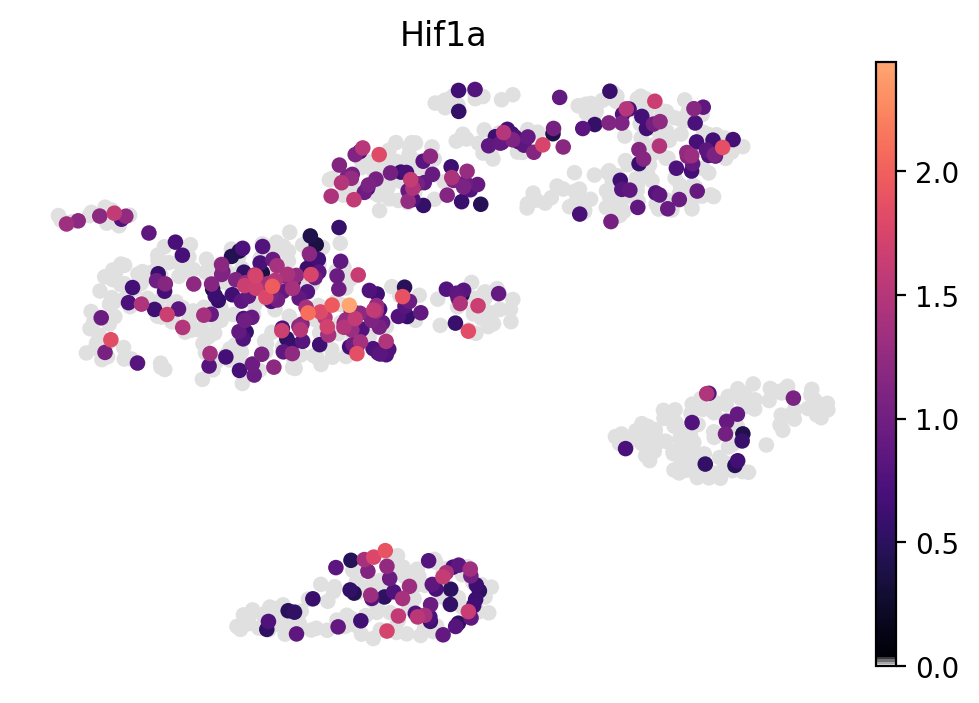

In [20]:
list_genes = ['Hif1a']
sc.pl.umap(adata_vasc, color=['batch',  'subtype',], ncols=3, frameon=False, cmap=magma)
sc.pl.umap(adata_vasc, color=list_genes, ncols=3, frameon=False, cmap=magma)

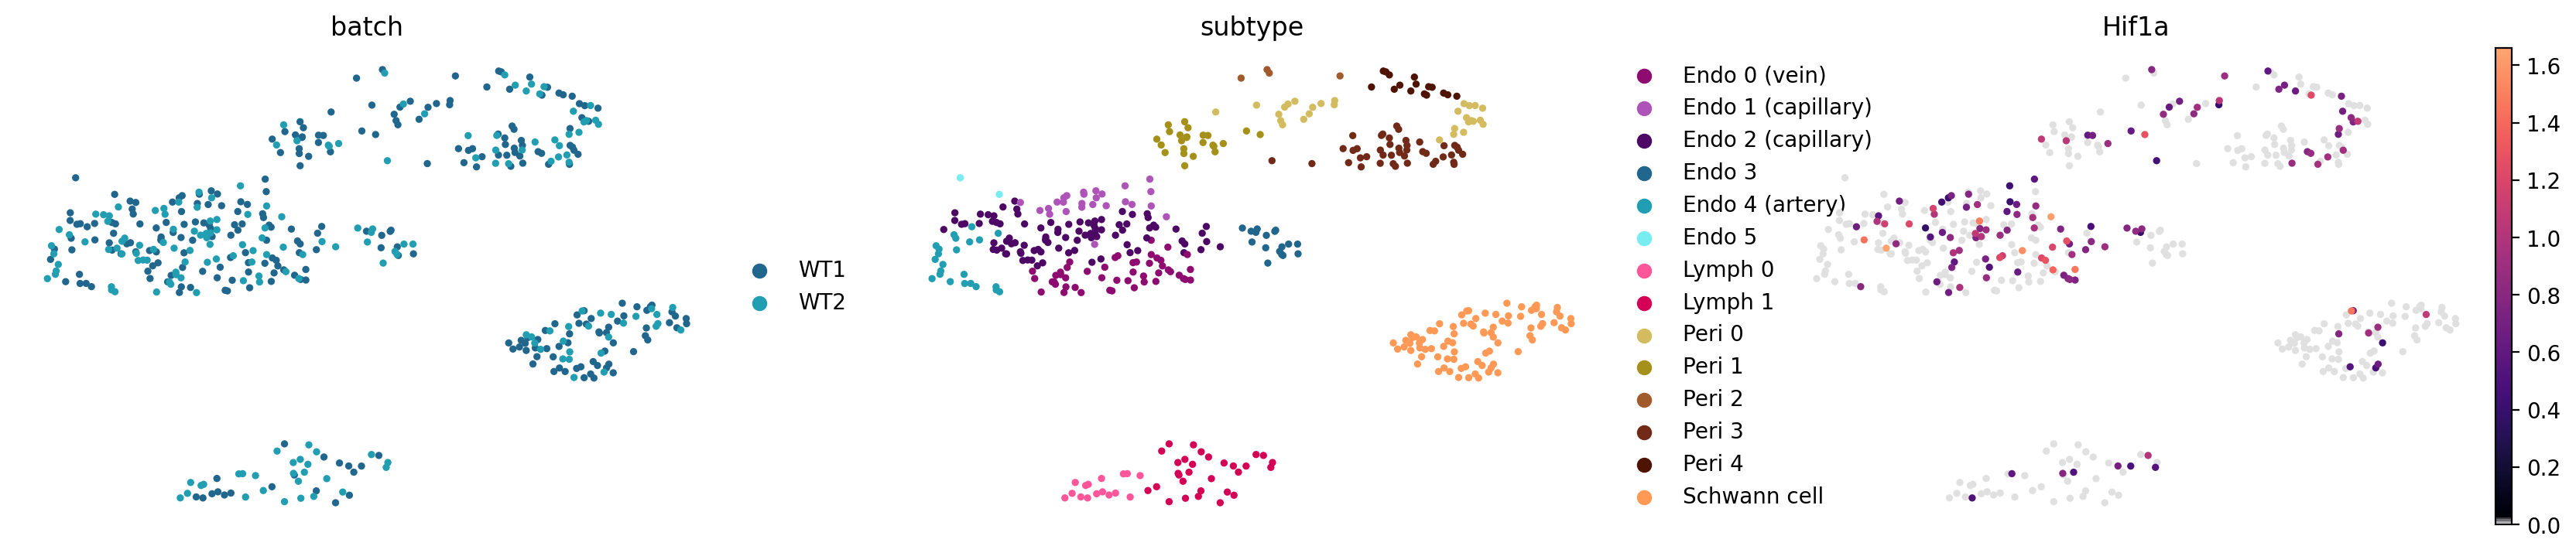

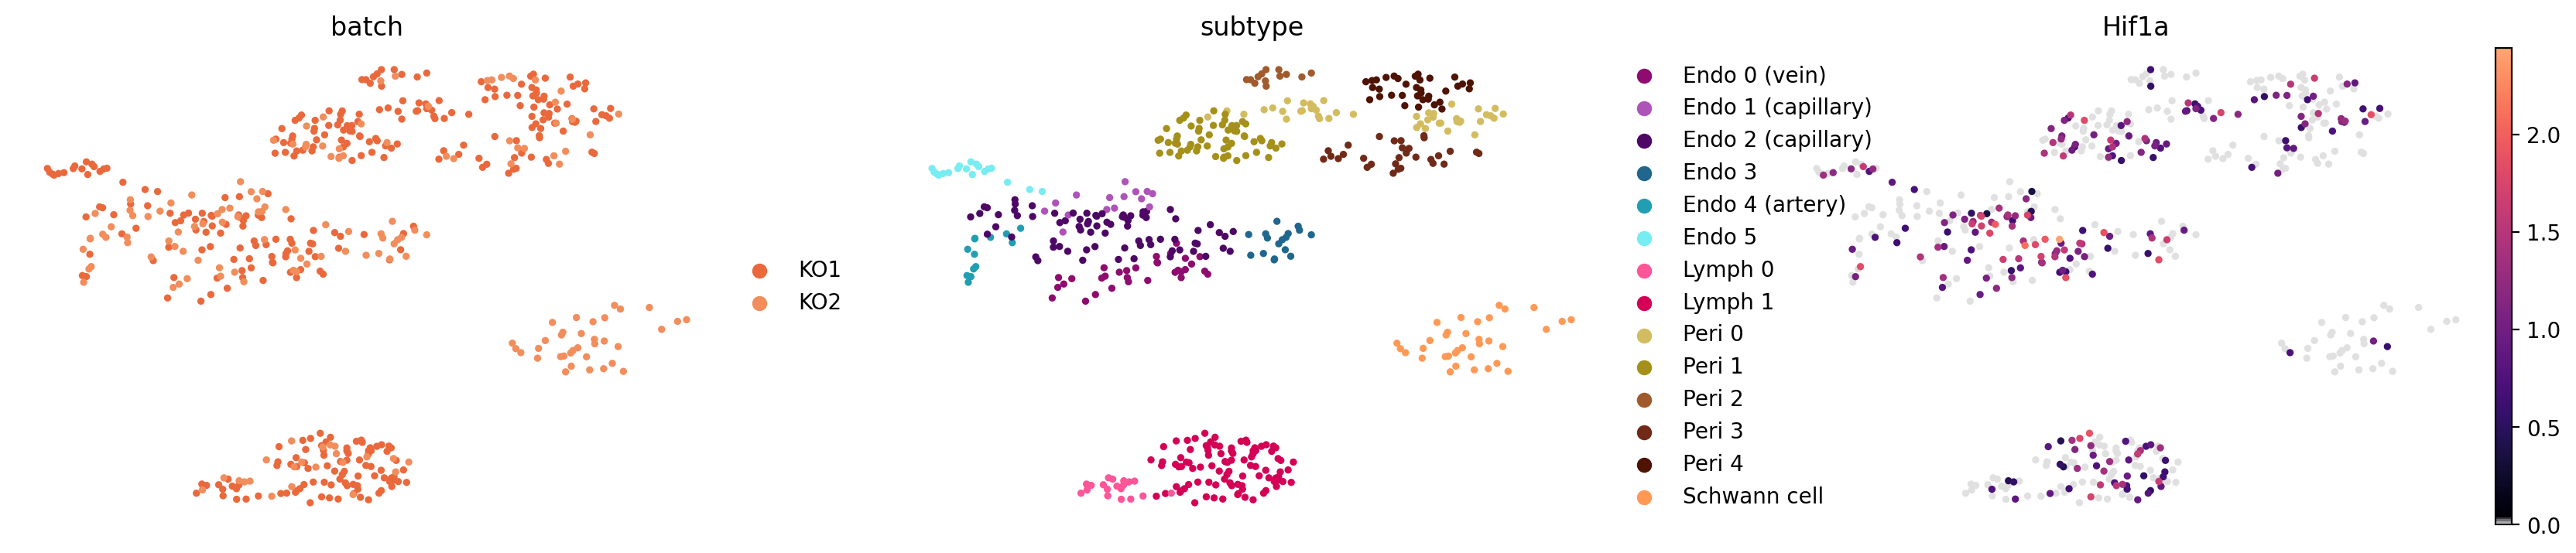

In [21]:
sc.pl.umap(adata_vasc[adata_vasc.obs['batch'].isin(['WT1', 'WT2'])], color=['batch', 'subtype',] + list_genes, ncols=4, frameon=False, cmap=magma, s=45)
sc.pl.umap(adata_vasc[adata_vasc.obs['batch'].isin(['KO1', 'KO2'])], color=['batch', 'subtype',] + list_genes, ncols=4, frameon=False, cmap=magma, s=45)

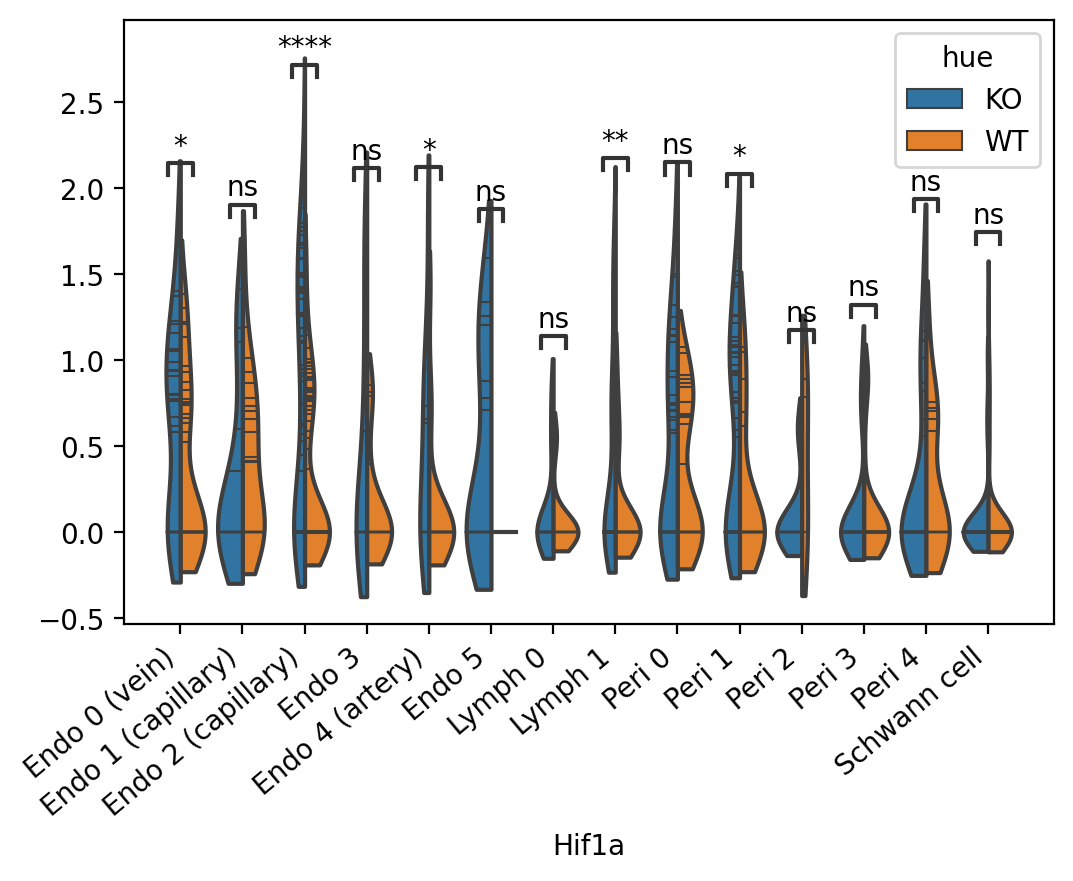

In [22]:
for gene in list_genes: 
    stat_annot_gene(gene, adata_vasc, dict_vasc, type_plot='violin', add_stats=True)

In [23]:
adata_vasc.write_h5ad('adatas/adata_vasculature.h5')